# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_new import LuvoirAPLC

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

## Instantiate a simple SM for mode plotting

I need to simplify this... I can make a child class like I did for the full LUVOIR simulator.

In [3]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

## Mode and eigenvalue units

Since the matrices got generated normalized to an aberration of 1 nm, everything stemming from the matrix will be in units of **nanometers**. --> This is the desired behaviour of course and is yet to be confirmed, which is one of the goals of this notebook.

In [4]:
eunit = 1e-9

## Also instantiate a LUVOR telescope

For cumulative contrast calculation.

> **ATTENTION:** the variable `apodizer_design` has to be correct for the data we are reading with the variable `savedpath` further below!!!

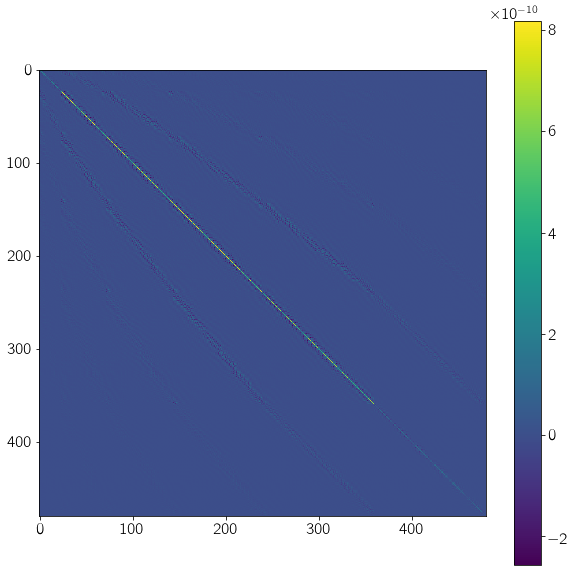

In [5]:
savedpath = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-09-15T22-28-50_luvoir-medium'   # large apodizer LUVOIR
matrix = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'PASTISmatrix_num_Multiple_Modes_MaxZer_4.fits'))
plt.figure(figsize=(10, 10))
plt.imshow(matrix)
plt.colorbar()

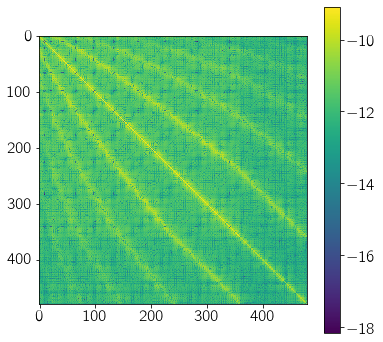

In [29]:
plt.figure(figsize=(6, 6))
plt.imshow(np.log10(np.abs(matrix)))
plt.colorbar()

In [7]:
# Instantiate LUVOIR
sampling = 4
apodizer_design = 'medium'
# This path is specific to the paths used in the LuvoirAPLC class
optics_input = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
luvoir = LuvoirAPLC(optics_input, apodizer_design, sampling)
luvoir.make_segment_zernike_primary(4)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


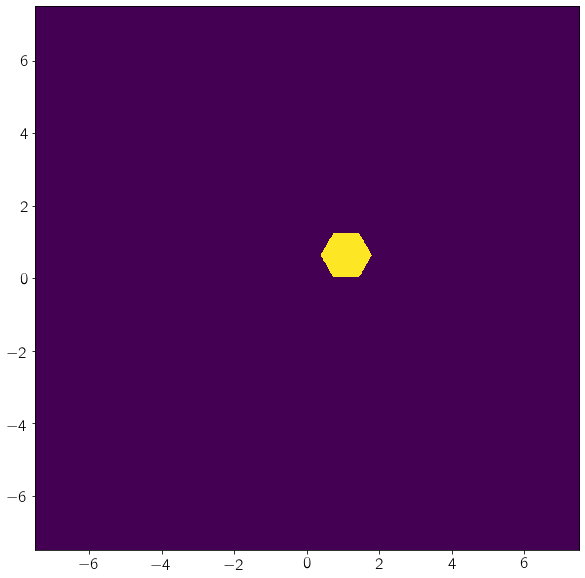

In [8]:
zernike_coeffs = np.zeros([4*120])
zernike_coeffs[4] = eunit
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
plt.figure(figsize=(10, 10))
hc.imshow_field(wf_sm.phase)

In [9]:
zernike_coeffs = np.zeros([4*120])
zernike_coeffs[4] = 0
luvoir.sm.actuators = zernike_coeffs
wf_sm = luvoir.sm(luvoir.wf_aper)
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()

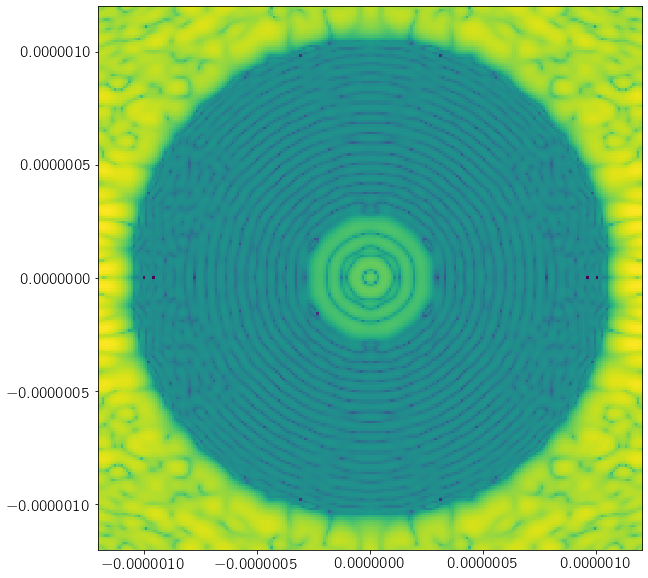

In [10]:
psf_unaber, ref = luvoir.calc_psf(ref=True)
norm = ref.max()
plt.figure(figsize=(10, 10))
hc.imshow_field(psf_unaber, norm=LogNorm())

In [11]:
# Make dark hole
dh_outer = hc.circular_aperture(2*luvoir.apod_dict[apodizer_design]['owa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_inner = hc.circular_aperture(2*luvoir.apod_dict[apodizer_design]['iwa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

In [12]:
dh_intensity = psf_unaber/norm * dh_mask
baseline_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
print('contrast:', baseline_contrast)

contrast: 3.924822663883738e-11


## Read eigenmodes and eigenvalues

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


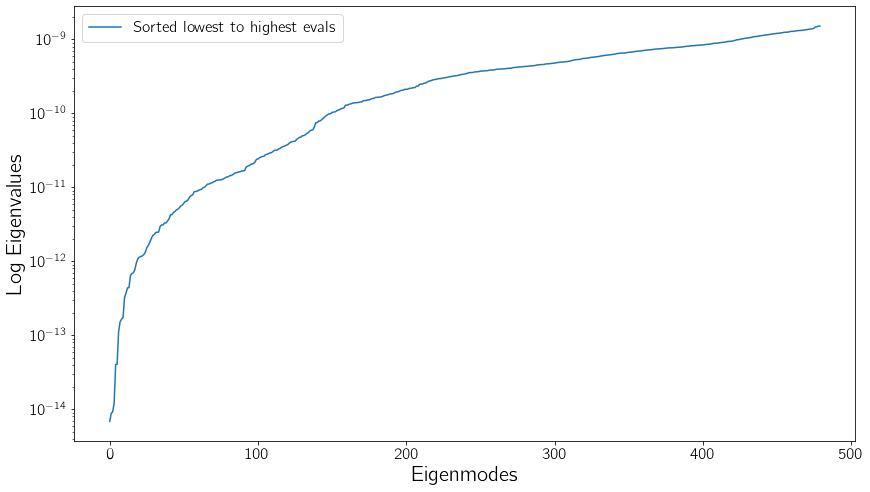

In [13]:
evals, evecs = np.linalg.eig(matrix)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('Eigenmodes')
plt.ylabel('Log Eigenvalues')
plt.legend()

## Stability requirements

### Static contrast and static contribution

According to Lucie's paper, we can get the maximum aberration $\sigma_p$ we can allow per mode $p$ if we want to obtain a contrast $C$ directly from the according eigenvalue $\lambda_p$.

$$\sigma_p = \sqrt{\frac{C_p}{\lambda_p}}$$

Where $C_p$ is the contrast contribution from mode $p$ only. For simplicity, we assume that all modes have the same contribution to the total contrast $C$, meaning

$$C = C_1 + C_2 + ... + C_N$$

with $N$ being the total number of modes. This also means

$$C_p = \frac{C}{N}$$

Since we have one mode that has a really low eigenvalue and essentially on contribution, we can take that mode out and assume that the other $N-1$ modes bear all the contrast contributions, changing it to

$$C_p = C_1 + C_2 + ... + C_{N-1}$$

and

$$C_p = \frac{C}{N-1}$$

So we can calculate the maximum ocntribution of a mode $\sigma_p$ with

$$\sigma_p = \sqrt{\frac{C}{(N-1)\lambda_p}}$$

We have 120 segments, so $N=120$ and we will aim to achieve a static contrast of $C = 10^{-10}$.

Note how we start numbering at 1 here, to stay consistent with our segment numbering, but when doing these things in Python we need to start numbering at 0.

Skype with Lucie, have to include baseline contrast $C_0$:

$$\sigma_p = \sqrt{\frac{C-C_0}{(N-1)\lambda_p}}$$

In [14]:
number_of_modes = luvoir.sm.num_actuators

In [15]:
c_stat = 1e-11
print('Static contrast: {}'.format(c_stat))
print('N = {}'.format(number_of_modes))

Static contrast: 1e-11
N = 480


In [16]:
# Calculate single sigma - remember that we start numbering at 0 because of python
def get_sigma(cstat, nseg, eigenval, c_zero):
#     sigma = np.sqrt((cstat - c_zero) / ((nseg-1)*eigenval))
    sigma = np.sqrt((cstat) / ((nseg-1)*eigenval))

    return sigma

In [17]:
p = 1
sigma_p = get_sigma(c_stat, number_of_modes, sorted_evals[p], baseline_contrast)
print(sigma_p)

1.5427744189916925


In [18]:
# Do them all at once
sigmas = get_sigma(c_stat, number_of_modes, sorted_evals, baseline_contrast)
#print(sigmas)

# Save them
#np.savetxt(os.path.join(savedpath, 'results', 'sigmas.txt'), sigmas)

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

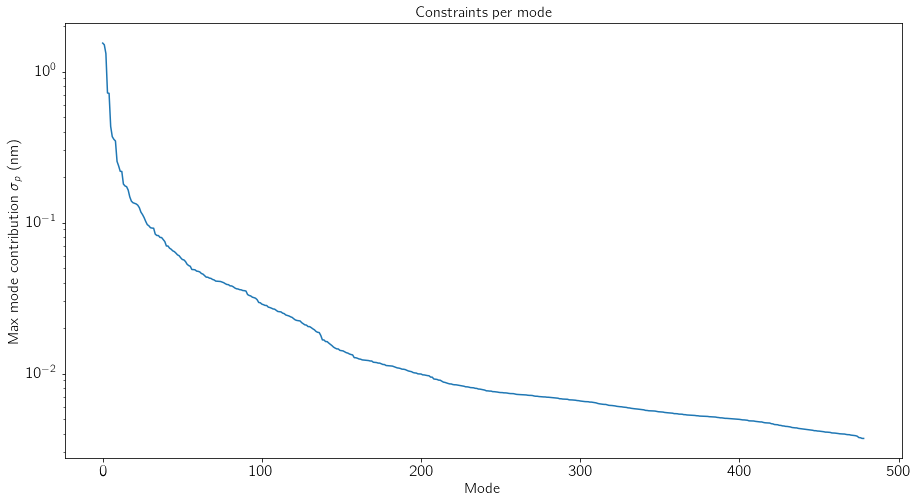

In [19]:
plt.figure(figsize=(15, 8))
plt.plot(sigmas[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

### Dynamic contast and dynamic contribution

We want $\Delta C = 10^{-11}$. This "dynamic contast" is the error on the contrast $C$ which we want to limit, so we write it as

$$\Delta C = \sqrt{\Delta C_1^2 + \Delta C_2^2 + ... \Delta C_N^2} = \sqrt{N \Delta C_p^2} = \sqrt{N} \Delta C_p$$

which also means

$$\Delta C_p = \frac{C}{\sqrt{N}}$$

and then again because we discard that non-contributing mode, we actually have

$$\Delta C_p = \frac{C}{\sqrt{N-1}}$$

For the $\Delta \sigma_p$ we can use the same equation like for the $\sigma_p$, but we plug in $\Delta C$ instead of $C$.

$$\Delta \sigma_p = \sqrt{\frac{\Delta C}{\lambda_p}} = \sqrt{\frac{\Delta C}{\sqrt{(N-1)}\ \lambda_p}}$$

In [20]:
c_dyn = 1e-11

# Calculate the Delta Cs
def get_delta_sigma(cdyn, nseg, eigenval):
    del_sigma = np.sqrt(cdyn / (np.sqrt(nseg-1)*eigenval))
    return del_sigma

In [21]:
del_sigmas = get_delta_sigma(c_dyn, number_of_modes, sorted_evals)
#print(del_sigmas)

# Save them
#np.savetxt(os.path.join(savedpath, 'results', 'delta_sigmas.txt'), del_sigmas)

Text(0, 0.5, 'Max mode contribution $\\Delta \\sigma_p$ (nm)')

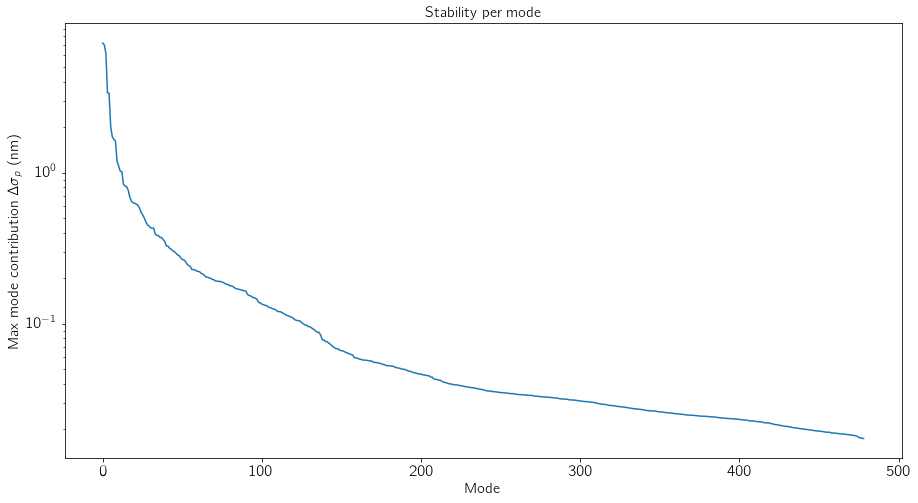

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(del_sigmas[1:])
plt.semilogy()
plt.title('Stability per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\Delta \sigma_p$ (nm)', size=15)

## Segment based constraints

In [23]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16

In [24]:
c_target = 1e-10

In [25]:
number_of_modes = luvoir.sm.num_actuators
# Calculate the inverse of the pastis MODE matrix
modestosegs = np.linalg.pinv(sorted_evecs)

# # Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
# c_avg = []
# for i in range(number_of_modes):
#     c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) + baseline_contrast)

# # Calculate segment requirements
# mu_map = np.sqrt(
#     ((c_target - baseline_contrast) / number_of_modes) / (np.dot(c_avg - baseline_contrast, np.square(modestosegs))))

# Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
c_avg = []
for i in range(number_of_modes):
    c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) )

# Calculate segment requirements
mu_map = np.sqrt(
    ((c_target ) / number_of_modes) / (np.dot(c_avg, np.square(modestosegs))))

In [31]:
# zernike_coeffs = mu_map*eunit/2
# luvoir.sm.actuators = zernike_coeffs
# luvoir.sm(luvoir.wf_aper)
# psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield')
# plt.figure(figsize=(10, 10))
# hc.imshow_field(psf.intensity/norm, norm=LogNorm())
# plt.colorbar()
# dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
# test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
# print('contrast:', test_contrast)

In [33]:
N_zernike = 4
zernike_coeffs_numaps = np.zeros([N_zernike,number_of_modes])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([number_of_modes])
    for pp in range(120):
        zernike_coeffs_tmp[qq+(pp)*N_zernike] = mu_map[qq+(pp)*N_zernike]
    zernike_coeffs_numaps[qq] = zernike_coeffs_tmp

In [34]:
nu_maps = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps[qq]/2
    luvoir.sm.actuators = zernike_coeffs
    nu_maps.append(luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0.5, 1, 'Segment Level Piston ')

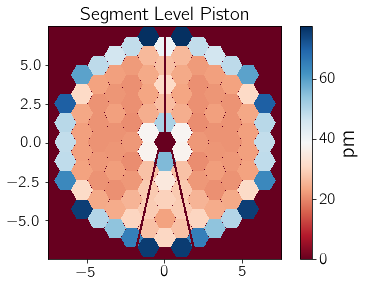

In [36]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level Piston ')

contrast: 1.6456593538649357e-12


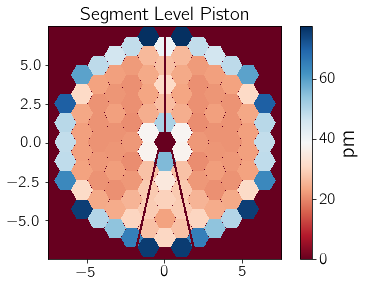

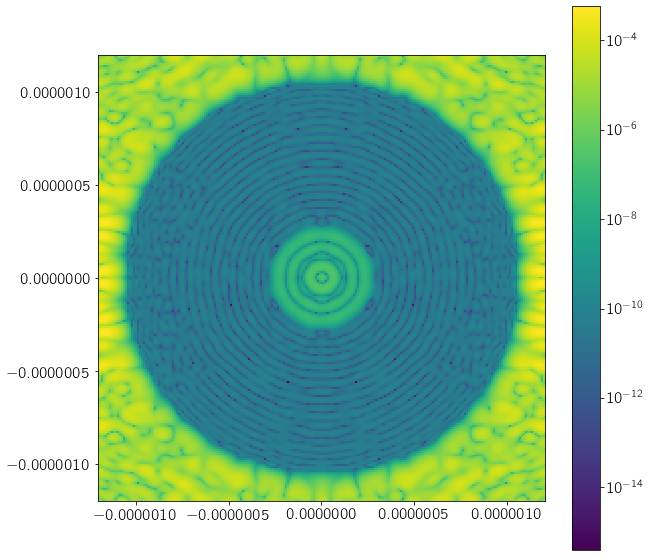

In [37]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level Piston ')
zernike_coeffs = zernike_coeffs_numaps[0]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])- baseline_contrast
print('contrast:', test_contrast)

contrast: 2.3500624721920724e-11


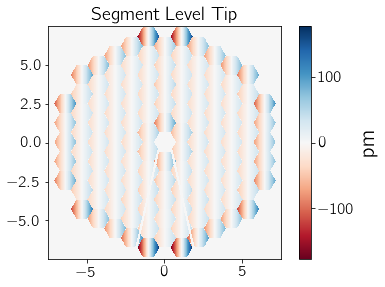

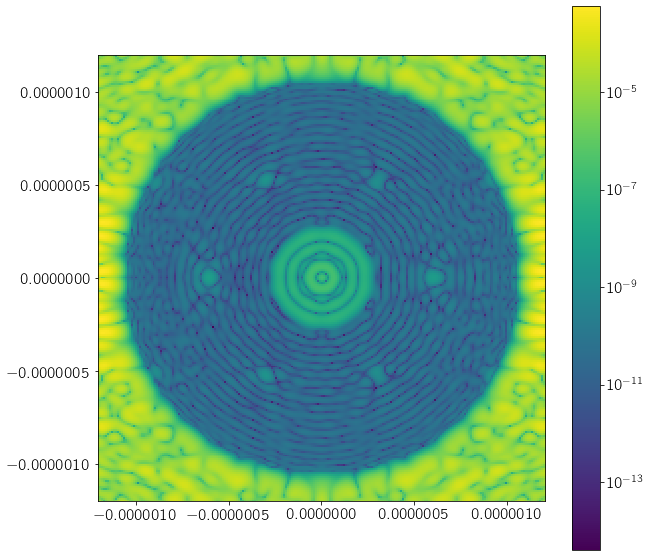

In [38]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[1]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level Tip ')
zernike_coeffs = zernike_coeffs_numaps[1]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

contrast: 2.3369635593827038e-11


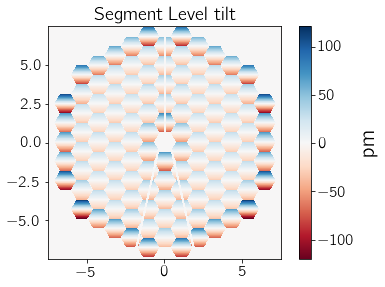

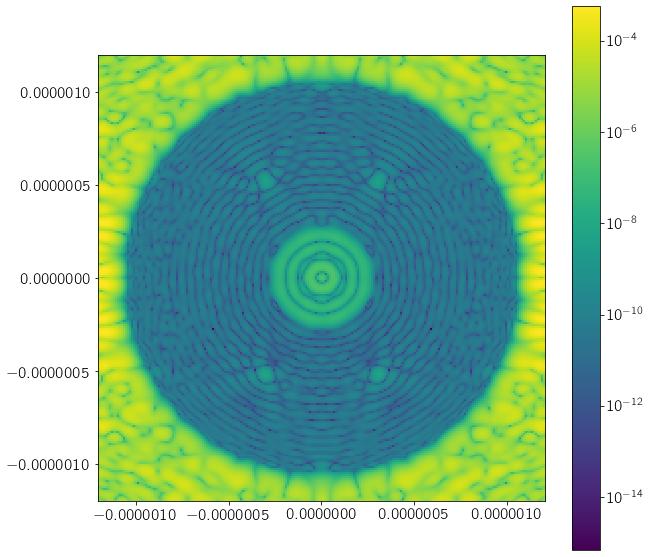

In [39]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[2]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segment Level tilt ')
zernike_coeffs = zernike_coeffs_numaps[2]*eunit / 2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

contrast: 3.059988326188137e-11


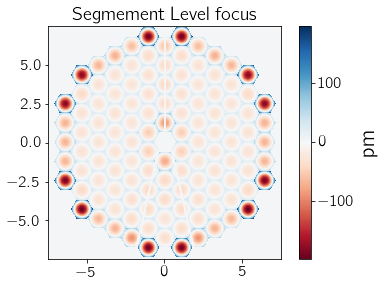

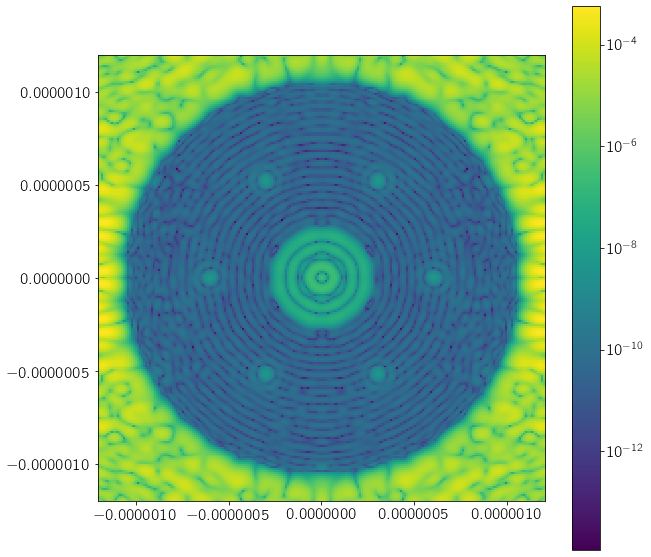

In [40]:
fig, ax = plt.subplots(ncols=1)
img1 = hc.imshow_field(nu_maps[3]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
clb = fig.colorbar(img1)
clb.set_label('pm', rotation=90)
plt.tight_layout(h_pad=1)
plt.title('Segmement Level focus ')
zernike_coeffs = zernike_coeffs_numaps[3]*eunit/2
luvoir.sm.actuators = zernike_coeffs
luvoir.sm(luvoir.wf_aper)
psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
plt.figure(figsize=(10, 10))
hc.imshow_field(psf/norm, norm=LogNorm())
plt.colorbar()
dh_intensity = psf/norm * dh_mask
test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - baseline_contrast
print('contrast:', test_contrast)

In [46]:
psf

Field([6.52846130e+11, 3.61271495e+11, 1.10556222e+11, ...,
       1.11514391e+11, 3.62915014e+11, 6.54941062e+11])

In [47]:
n_repeat = 300
all_contr_rand_seg = []
all_random_maps = []
for rep in range(n_repeat):
    print('Segment realization {}/{}'.format(rep + 1, n_repeat))
    zernike_coeffs = np.random.uniform(-mu_map*eunit,mu_map*eunit,number_of_modes)
    luvoir.sm.actuators = zernike_coeffs
    luvoir.sm(luvoir.wf_aper)
    psf, ref = luvoir.calc_psf(ref=True)
#     plt.figure(figsize=(10, 10))
#     hc.imshow_field(psf.intensity/norm, norm=LogNorm())
#     plt.colorbar()
#     dh_intensity = np.abs(psf.electric_field - psf_unaber.electric_field)**2/norm 
    dh_intensity = psf/norm 
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])
    all_contr_rand_seg.append(test_contrast) 
    print('contrast:', test_contrast)
    

Segment realization 1/300
contrast: 1.0566060851974682e-05
Segment realization 2/300
contrast: 1.0566065645959121e-05
Segment realization 3/300
contrast: 1.0566056104220159e-05
Segment realization 4/300
contrast: 1.0566065125581763e-05
Segment realization 5/300
contrast: 1.0566053955572002e-05
Segment realization 6/300
contrast: 1.0566054692859908e-05
Segment realization 7/300
contrast: 1.05660609709192e-05
Segment realization 8/300
contrast: 1.056606714464604e-05
Segment realization 9/300
contrast: 1.0566054420849419e-05
Segment realization 10/300
contrast: 1.0566061237175426e-05
Segment realization 11/300
contrast: 1.0566067226717359e-05
Segment realization 12/300
contrast: 1.0566050535380663e-05
Segment realization 13/300
contrast: 1.0566056815083766e-05
Segment realization 14/300
contrast: 1.0566058410592923e-05
Segment realization 15/300
contrast: 1.0566059942006874e-05
Segment realization 16/300
contrast: 1.0566052165836726e-05
Segment realization 17/300
contrast: 1.0566057401413

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16, 10))
plt.hist(all_contr_rand_seg,30)
plt.title('E2E raw contrast, {} realizations, target contrast 1e-10'.format(n_repeat), size=20)
plt.xlabel('Mean contrast in DH', size=20)
plt.ylabel('PDF', size=20)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=25)